# Importing Libraries

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Working with Spectrograms

In [21]:
data_path = 'data/stock_technical_data/'

In [22]:
df = pd.read_csv(data_path + 'AUBANK.NS.csv', index_col=0)

In [23]:
sample_data = df['Close'].values

print(len(sample_data))


1355


In [24]:
reduced_data = sample_data[:20]

print(len(reduced_data))

20


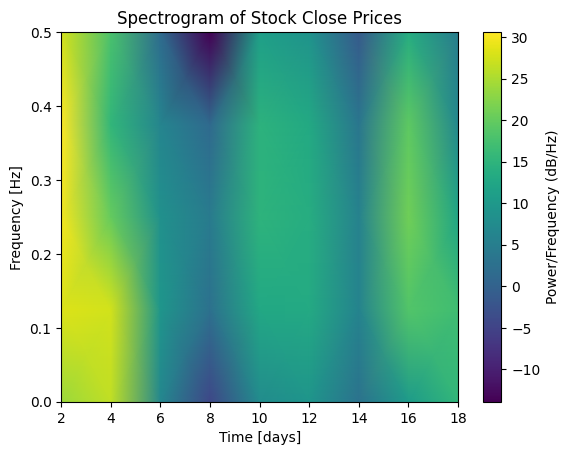

In [25]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(reduced_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=2, nfft=8, detrend='constant', scaling='density', mode='psd')

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [days]')
plt.title('Spectrogram of Stock Close Prices')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

# Setting up the Prediction Models

In [26]:
def generate_spectrogram(window_data):
    frequencies, times, Sxx = spectrogram(window_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=2, nfft=8, detrend='constant', scaling='density', mode='psd')
    return frequencies, times, Sxx

1000


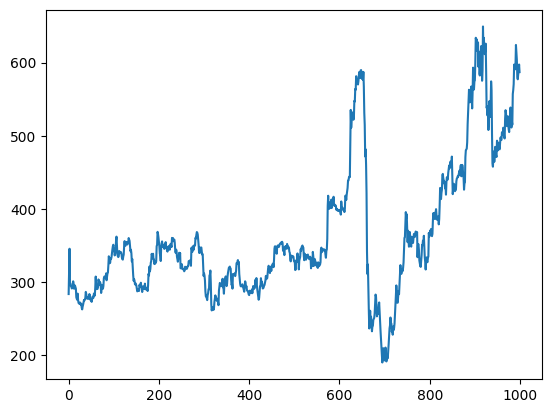

In [27]:
noofdays = 25

close_prices = df['Close'].values
close_prices = close_prices[0:1000]
print(len(close_prices))

# plot the close prices
plt.plot(close_prices)

In [28]:
X = []
y = []

for i in range(len(close_prices) - noofdays):
    window_data = close_prices[i:i + noofdays]
    spectrogram_data = generate_spectrogram(window_data)
    X.append(spectrogram_data[2])
    # Label: 1 if price on day 26 is greater than day 25, else 0
    label = 1 if close_prices[i + noofdays] > close_prices[i + noofdays - 1] else 0
    y.append(label)

In [29]:
X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Reshape X to have the appropriate shape (samples, channels, height, width)
X = X.unsqueeze(1)  # Adding a channel dimension (since we have grayscale images)

(975, 5, 11) (975,)


In [30]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(X.shape, y.shape)

torch.Size([975, 1, 5, 11]) torch.Size([975])


C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_15784\2224203128.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
C:\Users\Pdogg Windows10\AppData\Local\Temp\ipykernel_15784\2224203128.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)


In [33]:
# Creating a dataset and DataLoader for training
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the CNN model
class StockPriceCNN(nn.Module):
    def __init__(self):
        super(StockPriceCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Instantiate the model, define the loss function and the optimizer
model = StockPriceCNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10  # Adjust as needed
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in loader:
        labels = labels.unsqueeze(1)  # Reshape labels to match the output shape

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(loader):.4f}')

# Save the model after training
torch.save(model.state_dict(), 'stock_price_predictor_cnn.pth')

print('Training complete. Model saved as stock_price_predictor_cnn.pth')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x128 and 3136x128)